In [1]:
import sys 
import xarray as xr
import numpy as np
import os 
import math
coords = xr.open_dataset('/home/jvalenti/MOAD/grid/coordinates_seagrid_SalishSea201702.nc', decode_times=False)
mask = xr.open_dataset('/home/jvalenti/MOAD/grid2/mesh_mask202108_TDV.nc')

filename=['outfall_31days.nc']

In [2]:
def latT(lat):
    return np.cos(lat*(math.pi/180))

def count_inside_grid_cell(center_x, center_y, cell_width, cell_height, x,y):
    deg2met = 111319.5
    cell_width = cell_width/(deg2met*latT(center_y))
    cell_height = cell_height/deg2met
    min_x = np.array(center_x - cell_width / 2)
    max_x = np.array(center_x + cell_width / 2)
    min_y = np.array(center_y - cell_height / 2)
    max_y = np.array(center_y + cell_height / 2)
    inside_mask = np.logical_and.reduce([
        min_x[:, np.newaxis] <= x,
        x <= max_x[:, np.newaxis],
        min_y[:, np.newaxis] <= y,
        y <= max_y[:, np.newaxis]
    ])
    c = np.sum(inside_mask,axis=1)
    return c



ds = xr.open_dataset(filename[0],decode_times=False)
MFc = 5e6
zlevels = [0,5,10]
DS=ds.to_dataframe()
#DS = DS[DS.z < 800]
DS = DS[DS.status==1]
lat = coords.nav_lat
lon = coords.nav_lon
td = mask.totaldepth
cell_width = coords.e1t[0,:,:]
cell_height = coords.e2t[0,:,:]
x = np.array(DS.lon)
y = np.array(DS.lat)
z = np.array(DS.z)

In [4]:
for k in range(len(zlevels)):
    print(f'{k} level starting.')  

0 level starting.
1 level starting.
2 level starting.


In [10]:
conc = np.zeros((len(zlevels),coords.nav_lon.shape[0],coords.nav_lon.shape[1]))
for k in range(len(zlevels)):
    print(f'{k} level starting.')  
    for j in range(coords.nav_lon.shape[0]):
        zmin = int(zlevels[k])
        try:
            zmax = int(zlevels[k+1])
        except IndexError:
            zmax = 800
        X = x[np.logical_and(z >= zmin, z < zmax)]
        Y = y[np.logical_and(z >= zmin, z < zmax)]
        if zmax==800:
            BOXvolume = np.array((cell_width[j,:]* cell_height[j,:]*(td[j,:]-zmin)))
        else:
            BOXvolume = np.array((cell_width[j,:]* cell_height[j,:]*(zmax-zmin)))
        conc[k,j,:]+= count_inside_grid_cell(lon[j,:], lat[j,:], cell_width[j,:], cell_height[j,:],X,Y)*MFc/BOXvolume

0 level starting.
1 level starting.
2 level starting.


/tmp/ipykernel_6083/1522587918.py:16: RuntimeWarning: invalid value encountered in divide
  conc[k,j,:]+= count_inside_grid_cell(lon[j,:], lat[j,:], cell_width[j,:], cell_height[j,:],X,Y)*MFc/BOXvolume


IndexError: index 5 is out of bounds for axis 0 with size 5

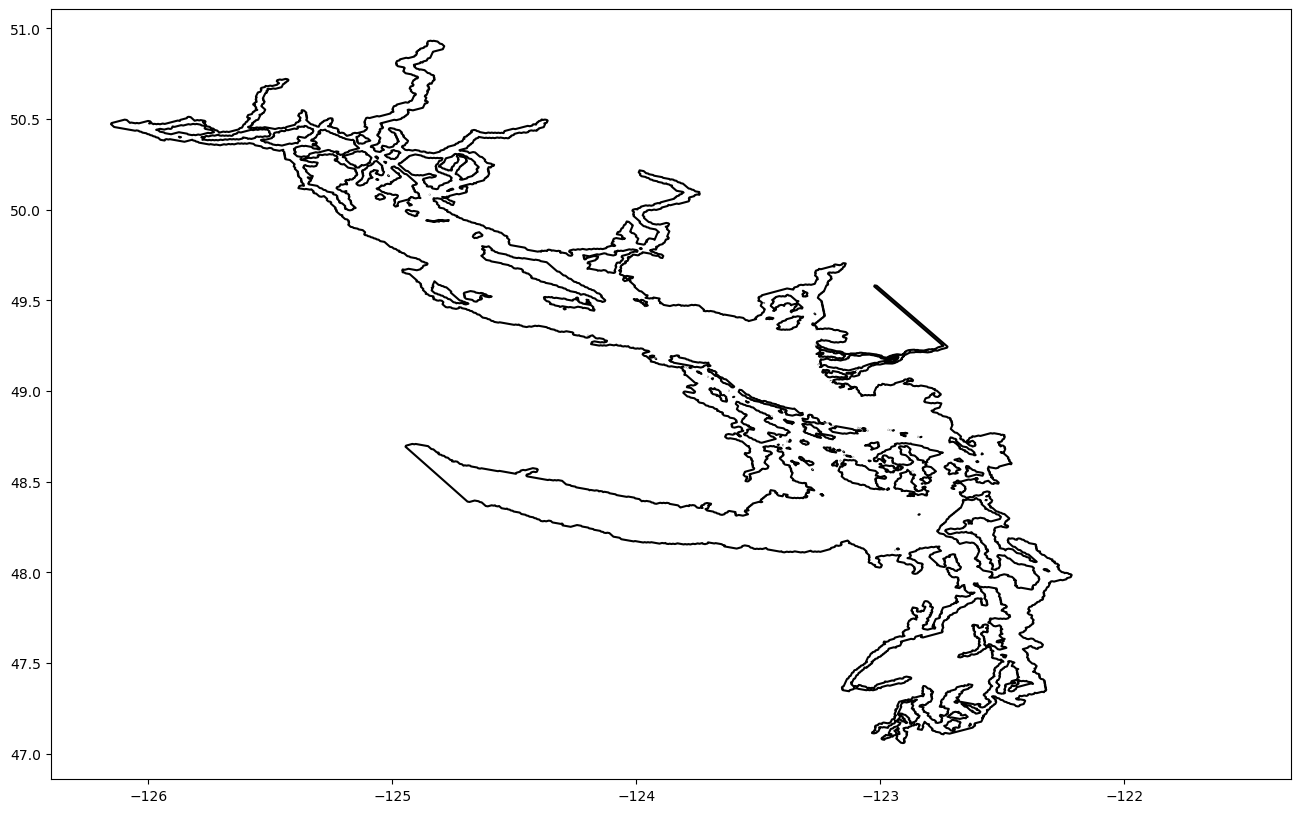

In [59]:
from matplotlib import pyplot as plt, animation, rc,colors
import cmocean

cm = cmocean.cm.dense
conc = np.load('/ocean/jvalenti/MOAD/concentration_31days.npy')
##ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
#ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
fig, ax = plt.subplots(1,1,figsize=(16, 10))
ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
aa = ax.contourf(coords.nav_lon, coords.nav_lat,conc[0,:,:],levels = np.linspace(0,50,12), extend='both')
aa.cmap.set_over('orange')
aa.cmap.set_under('white')
plt.colorbar(aa)
ax.set_aspect(1/np.sin(np.deg2rad(49)))
ax.set_title('All time')